In [43]:
import copy
import math

import numpy as np
import time

# Simulated Annealing（1 point）

Solve the Sudoku problem with Simulated Annealing. You can design your own algorithm or simply refer to [Metaheuristics_can_solve_Sudoku_puzzles](https://www.researchgate.net/publication/220403361_Metaheuristics_can_solve_Sudoku_puzzles). 


### DDL: 22:00, Oct.20
The practice will be checked in this lab class or the next lab class(before **Oct.20**) by teachers or SAs. 
#### What will be tested: 
* That you understand every line of your code, not just copy from somewhere 
* That your program compiles correctly
* Correctness of the program logic 
* That the result is obtained in a reasonable time 

#### Grading: 
* Submissions in this lab class: 1.1 points.
* Submissions on time: 1 point.
* Late submissions within 2 weeks after the deadline (Oct.20) : 0.8 points.


The code provided below starts with making a problem instance and ends by visualizing the running process of SA.

In [44]:
# making a problem instance
def make_grid_python(n):
    grid = np.empty((n**2, n**2), int)
    x = 0
    for i in range(n):
        for j in range(n):
            for k in range(n**2):
                grid[n*i+j, k] = x%(n**2) + 1
                x += 1
            x += n
        x += 1
    return grid

def make_grid_numpy(n):
    return np.fromfunction(lambda i, j: (i*n+i//n+j)%(n**2)+1, (n**2, n**2), dtype=int)

# a comparison between native python and numpy
# vary n to see their performances
n = 10
%timeit make_grid_python(n)
%timeit make_grid_numpy(n)

# test
grid = make_grid_numpy(3)
grid

4.21 ms ± 48.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
77.9 µs ± 861 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [4, 5, 6, 7, 8, 9, 1, 2, 3],
       [7, 8, 9, 1, 2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6, 7, 8, 9, 1],
       [5, 6, 7, 8, 9, 1, 2, 3, 4],
       [8, 9, 1, 2, 3, 4, 5, 6, 7],
       [3, 4, 5, 6, 7, 8, 9, 1, 2],
       [6, 7, 8, 9, 1, 2, 3, 4, 5],
       [9, 1, 2, 3, 4, 5, 6, 7, 8]])

In [45]:
import random


class Sudoku:
    @classmethod
    def create(cls, n, seed=303):
        rng = np.random.default_rng(seed)
        init_grid = make_grid_numpy(n)

        # randomly mask out some cells to create a problem instance
        # cells marked by *1* is given and fixed
        mask = rng.integers(0, 2, size=init_grid.shape)
        grid = init_grid*mask
        return cls(n, mask, grid, seed)

    def __init__(self, n, mask, grid, seed) -> None:
        self.seed = seed
        self.mask = mask
        self.grid = grid
        self.n = n
        self.all = set(range(1, n**2+1))

    def value(self):
        # TODO: evaluate the current state, return a scalar value. (cost function)
        score = 0
        for i in range(1, 10):
            score -= np.sum(np.all(self.grid != i, axis=1))
            score -= np.sum(np.all(self.grid != i, axis=0))
        return score

    def local_search(self):
        # TODO: apply your neighborhood search operator to get the next state
        zero_indices = np.argwhere(self.mask == 0)
        random_index = np.random.choice(len(zero_indices))

        # 获取随机选择的索引的i和j值
        selected_index = zero_indices[random_index]
        i, j = selected_index[0], selected_index[1]

        a = (int(i / 3) * 3)
        c = (int(j / 3) * 3)
        condition = (self.mask[a : a + 3, c : c + 3] == 0)
        zero_indices_1 = np.argwhere(condition)
        random_index_1 = np.random.choice(len(zero_indices_1))
        selected_index_1 = zero_indices_1[random_index_1]

        l, k = selected_index_1[0] + a, selected_index_1[1] + c

        next_state = copy.deepcopy(self)
        next_state.grid[i][j], next_state.grid[l][k] = next_state.grid[l][k], next_state.grid[i][j]
        # print(next_state.grid == self.grid)
        return next_state


    def init_solution(self):
        rng = np.random.default_rng(self.seed)
        n = self.n
        grid = self.grid.reshape(n, n, n, n).transpose(0, 2, 1, 3)
        for I in np.ndindex(n, n):
            idx = grid[I]==0
            grid[I][idx] = rng.permutation(list(self.all-set(grid[I].flat)))
        return self

    def __repr__(self) -> str:
        return self.grid.__repr__()

# test
sudoku = Sudoku.create(3)
sudoku.init_solution()
sudoku, sudoku.value()

(array([[9, 2, 3, 4, 3, 6, 8, 6, 9],
        [4, 5, 1, 7, 8, 9, 1, 2, 3],
        [7, 6, 8, 5, 2, 1, 4, 5, 7],
        [2, 3, 4, 3, 6, 7, 4, 9, 1],
        [5, 6, 7, 9, 1, 5, 5, 3, 8],
        [8, 9, 1, 8, 2, 4, 7, 2, 6],
        [3, 4, 5, 1, 9, 8, 4, 1, 2],
        [6, 7, 8, 7, 2, 4, 3, 6, 5],
        [9, 1, 2, 3, 6, 5, 9, 7, 8]], dtype=int64),
 -33)

In [46]:
def simulated_annealing(initial:Sudoku, schedule, halt, log_interval=200):
    state = initial.init_solution()
    t = 0           # time step
    T = schedule(t) # temperature
    f = [state.value()] # a recording of values
    rng = np.random.default_rng(state.seed)
    while not halt(T):

        T = schedule(t)

        new_state = state.local_search()
        new_value = new_state.value()
        origin_value = state.value()
        # TODO: implement the replacement here

        if origin_value < new_value:
            state = new_state
            f.append(state.value())
        else:
            ra = rng.random()
            # print(math.exp(-(origin_value - new_value) / T))
            if ra <= math.exp(-(origin_value - new_value) / T):
                state = new_state
                f.append(state.value())


        # update time and temperature
        if t % log_interval == 0:

            print(f"step {t}: T={T}, current_value={state.value()}")
        if new_value == 0:

            break

        t += 1
        T = schedule(t)

    print(f"step {t}: T={T}, current_value={state.value()}")
    return state, f

In [47]:
import matplotlib.pyplot as plt

# define your own schedule and halt condition
# run the algorithm on different n with different settings
n = 3
solution, record = simulated_annealing(
    initial=Sudoku.create(n), 
    schedule=lambda t: 0.999**t, 
    halt=lambda T: T<1e-7
)
solution, solution.value()

step 0: T=1.0, current_value=-33
step 200: T=0.8186488294786356, current_value=-11
step 400: T=0.6701859060067401, current_value=-14
step 600: T=0.5486469074854967, current_value=-9
step 800: T=0.4491491486100751, current_value=-9
step 1000: T=0.36769542477096373, current_value=-2
step 1041: T=0.35291753993304886, current_value=0


(array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
        [4, 5, 6, 7, 8, 9, 1, 2, 3],
        [7, 8, 9, 1, 2, 3, 4, 5, 6],
        [2, 3, 4, 5, 6, 7, 8, 9, 1],
        [5, 6, 7, 8, 9, 1, 2, 3, 4],
        [8, 9, 1, 2, 3, 4, 5, 6, 7],
        [3, 4, 5, 6, 7, 8, 9, 1, 2],
        [6, 7, 8, 9, 1, 2, 3, 4, 5],
        [9, 1, 2, 3, 4, 5, 6, 7, 8]], dtype=int64),
 0)

Text(0, 0.5, 'value')

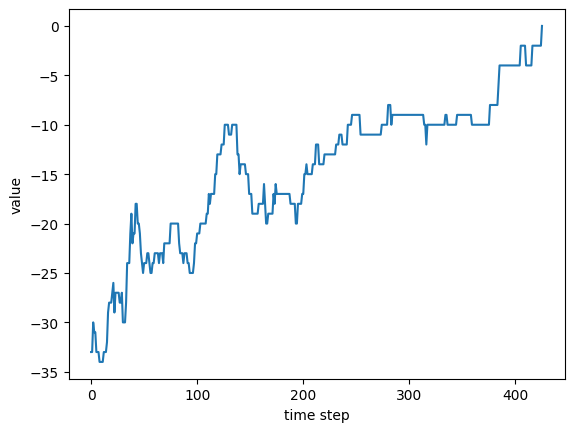

In [48]:
# visualize the curve
plt.plot(record)
plt.xlabel("time step")
plt.ylabel("value")